<a href="https://colab.research.google.com/github/Mrdiegolopes/Mrdiegolopes/blob/main/Criando_um_modelo_de_classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Carregar dados
df = pd.read_csv('journal.pone.0244129.s003.CSV', delimiter=';', decimal=',')

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')

# Definir target (supondo que 'death' é a variável alvo)
y = df['death']
df = df[df['death'].isin([0, 1])]

# Remover colunas irrelevantes (datas, IDs, etc.)
cols_to_drop = [
    'progressive number', 'date_symptoms_onset', 'date_admission',
    'date_test', 'date_exit', 'date_covid_diagnosis', 'id_test',
    'date_test2', 'day_x', 'week', 'admission_duration', 'timeonset',
    'dropping', 'b_day_disease'
]
X = df.drop(columns=cols_to_drop + ['death'])

# 3. Separar features e target
features = df.select_dtypes(include='number').columns.drop('death')
X = df[features]
y = df['death']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify=y,random_state=42)

# Imputar valores ausentes (média)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Treinar modelo inicial
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

 #Modelo Random Forest (binário)
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# Avaliação inicial
y_pred = rf.predict(X_test_imputed)
y_pred_proba = rf.predict_proba(X_test_imputed)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]  # Probabilidades da classe 1


print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted'):.2f}")

# Ajuste de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_imputed, y_train)
best_rf = grid_search.best_estimator_

# Validação cruzada com melhor modelo
cv_scores = cross_val_score(best_rf, X_train_imputed, y_train, cv=5, scoring='accuracy')
print(f"Acurácia média na validação cruzada: {cv_scores.mean():.2f}")

Acurácia: 0.99
Precisão: 0.99
Recall: 0.99
F1-score: 0.99
ROC-AUC: 0.98
Acurácia média na validação cruzada: 1.00


Dimensões do DataFrame: (10670, 75)

Tipos de dados:
 progressive number       int64
date_symptoms_onset     object
date_admission          object
date_test               object
date_exit               object
                        ...   
p_other                  int64
p_male                   int64
p_age                  float64
day_x                    int64
week                     int64
Length: 75, dtype: object

Valores ausentes por coluna:
 dimero         9692
dimero_ln      9692
eos_ln         9601
pcr            9337
pcr_ln         9337
               ... 
p_metabolic       0
p_other           0
p_male            0
day_x             0
week              0
Length: 75, dtype: int64

Estatísticas descritivas:
        progressive number         death       id_test           sex  \
count        10670.000000  10670.000000  10670.000000  10670.000000   
mean          1056.863918      4.816495    278.051546      1.325773   
std            169.981517     21.017948    351.493636      0.4

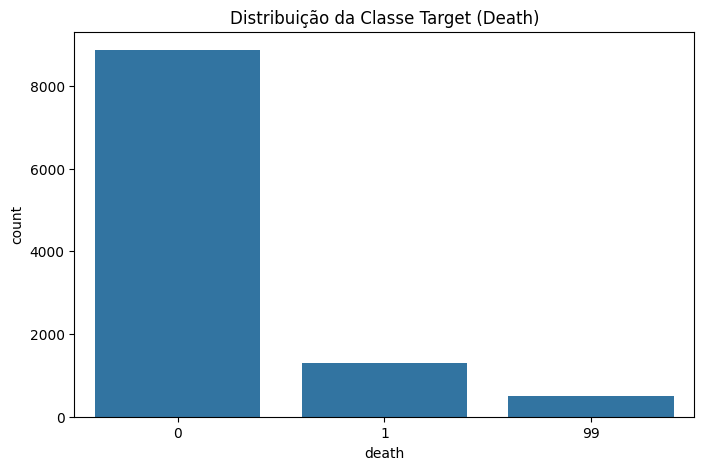

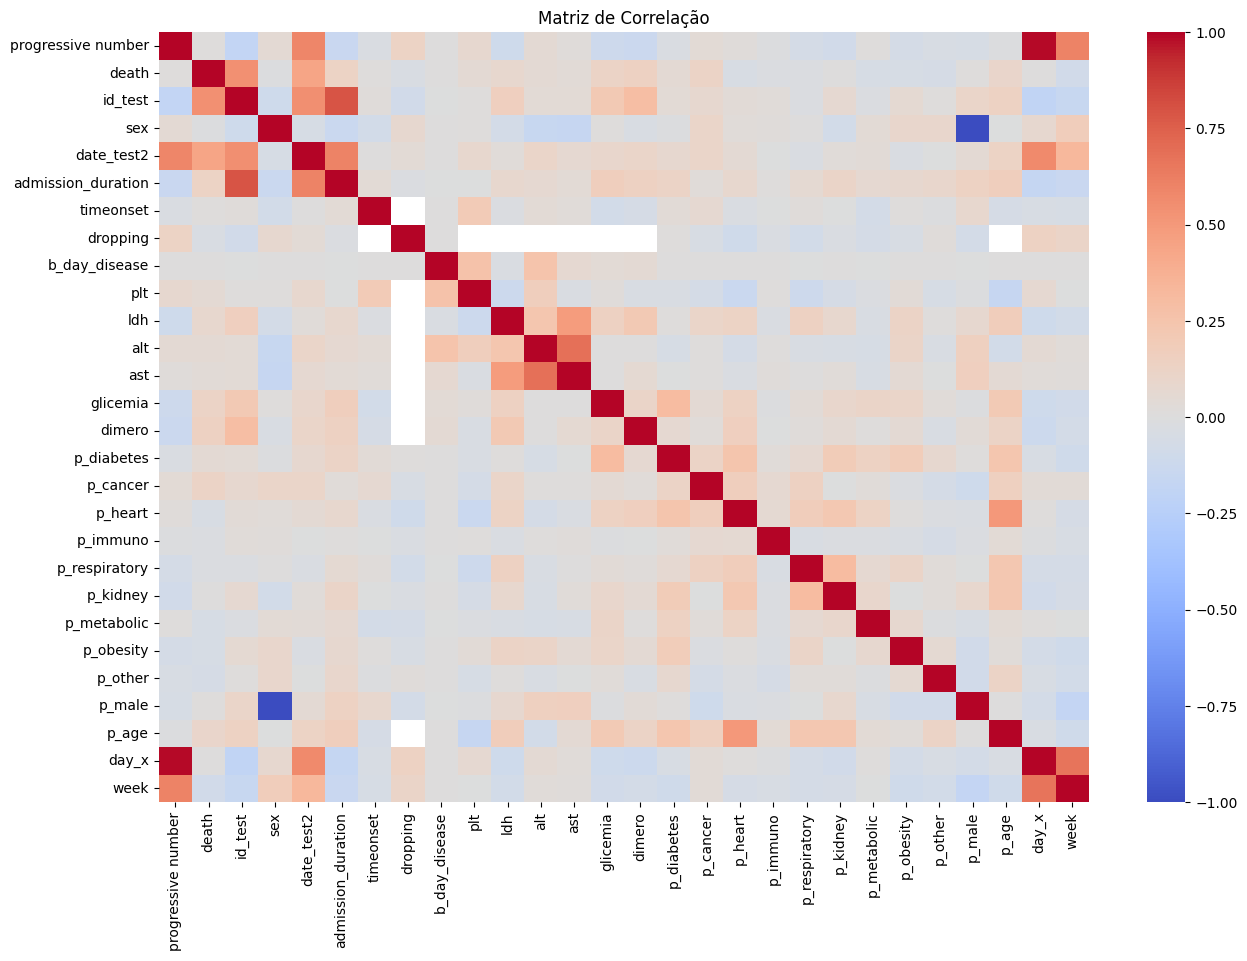

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
import shap

# Carregar dados
df = pd.read_csv('journal.pone.0244129.s003.CSV', delimiter=';', na_values=['', ' ', 'NA'])

# Análise inicial
print("Dimensões do DataFrame:", df.shape)
print("\nTipos de dados:\n", df.dtypes)
print("\nValores ausentes por coluna:\n", df.isnull().sum().sort_values(ascending=False))
print("\nEstatísticas descritivas:\n", df.describe())

# Plotar distribuição da variável target
plt.figure(figsize=(8,5))
sns.countplot(x='death', data=df)
plt.title('Distribuição da Classe Target (Death)')
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de Correlação')
plt.show()

#pre processamento
 pré-processamento dos dados é essencial para lidar com valores ausentes e normalizar variáveis, garantindo que o modelo não seja enviesado. A divisão dos dados em treino (80%) e teste (20%) permite avaliar o desempenho em dados não vistos, evitando overfitting.

#criação do modelo

O Random Forest é adequado para classificação devido à sua capacidade de lidar com dados complexos e não lineares. Parâmetros como n_estimators (número de árvores) e max_depth (profundidade máxima das árvores) controlam a complexidade do modelo. Valores altos de max_depth podem levar a overfitting, enquanto um número insuficiente de árvores (n_estimators) pode subutilizar os dados.


#treinamento e avaliação


Métricas-chave

Acurácia: Proporção de previsões corretas

Precisão: Proporção de verdadeiros positivos entre os previstos como positivos.

Recall: Proporção de verdadeiros positivos identificados corretamente.

F1-score: Média harmônica entre precisão e recall.

ROC-AUC: Área sob a curva ROC, que mede a capacidade de distinguir entre classes.

#Ajuste de Hiperparâmetros
A otimização de hiperparâmetros via GridSearchCV testa combinações de n_estimators, max_depth e min_samples_split, identificando a configuração que maximiza o desempenho.

#Validação Cruzada
A validação cruzada (ex: 5 folds) assegura que o modelo generalize bem, evitando dependência de uma única divisão dos dados.